In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.decomposition import NMF
from sklearn.metrics import jaccard_score
from collections import defaultdict

from jeopardy_funcs import *

%config InlineBackend.figure_format = 'retina';

# Jeopardy Questions Analysis
### By: Zachary Dougherty, Philip Navo and Kris Johnson
The goal of this project is identify trends in question topics over time. Due to the somewhat arbitrary nature of categorizing topics, we will be focusing our analysis primarily on comparing topic groups across different subsets of Jeopardy questions. Through our analyses, we hope to shed some light on the nature of Jeopardy! questions and how topics are distributed across time. We will be using Non-negative Matrix Factorization (NMF) as our primary method of topic modeling and an extension of the Jaccard similarity index to compare topic groups. In an effort to declutter this report, we have hidden much of our analysis in the file `jeopardy_funcs.py`. This script contains various useful functions, such as collecting topics, calculating our custom mean-max Jaccard similarity metric, visualizations, and more.

## Load in the Questions

In [71]:
df = pd.read_json('JEOPARDY_QUESTIONS1.json')

In [72]:
df = prep_data(df)

In [73]:
len(df)

216930

In [74]:
df['value'] = df['value'].fillna(0.0)
df['value'] = df['value'].apply(lambda x: int(x))

In [75]:
len(df)

216930

## Some fun EDA and summaries

In [4]:
f"{df.shape[0] - df['question'].nunique()} questions are repeats."

'1182 questions are repeats.'

In [5]:
f"There are {df['category'].nunique():,} unique categories in Jeopardy!"

'There are 27,995 unique categories in Jeopardy!'

Run this cell to get a random question and answer pair!

In [6]:
print(df.iloc[np.random.choice(range(df.shape[0]), 1)][['question','answer']].values)

[['a  targetblanksarah of the clue crew reports from the hostal dos reis catolicos in spaina  begun as a pilgrims hospice hostal dos reis catolicos in santiago de compostela was founded by a  targetblankthisa regal pair in '
  'Ferdinand & Isabella']]


In [8]:
W, H, df, vocab, tfidf_matrix = get_topics(df, 10, ret_tfidf=True)

In [11]:
start = time.time()
d = defaultdict(Counter)
vf = np.vectorize((lambda x: idx2word[x]))
idx2word = {idx: word for word, idx in vocab.items()}
checkpoints = [20_000 * _ for _ in range(tfidf_matrix.shape[0])]
topics = df.topic.values
assert len(topics), tfidf_matrix.shape[0]

for i, topic in enumerate(topics):
    _, cols = tfidf_matrix[i, :].nonzero()
    if len(cols) == 0:
        continue
    d[topic].update(set(vf(cols)))

    if i in checkpoints:
        print(f'{i:,}, {time.time() - start}')

0, 0.024499893188476562
20,000, 42.980021953582764
40,000, 87.61569690704346
60,000, 134.621591091156
80,000, 177.93310284614563
100,000, 222.23188471794128
120,000, 266.87919998168945
140,000, 311.1497097015381
160,000, 355.4764280319214
180,000, 398.88257479667664
200,000, 442.7470107078552


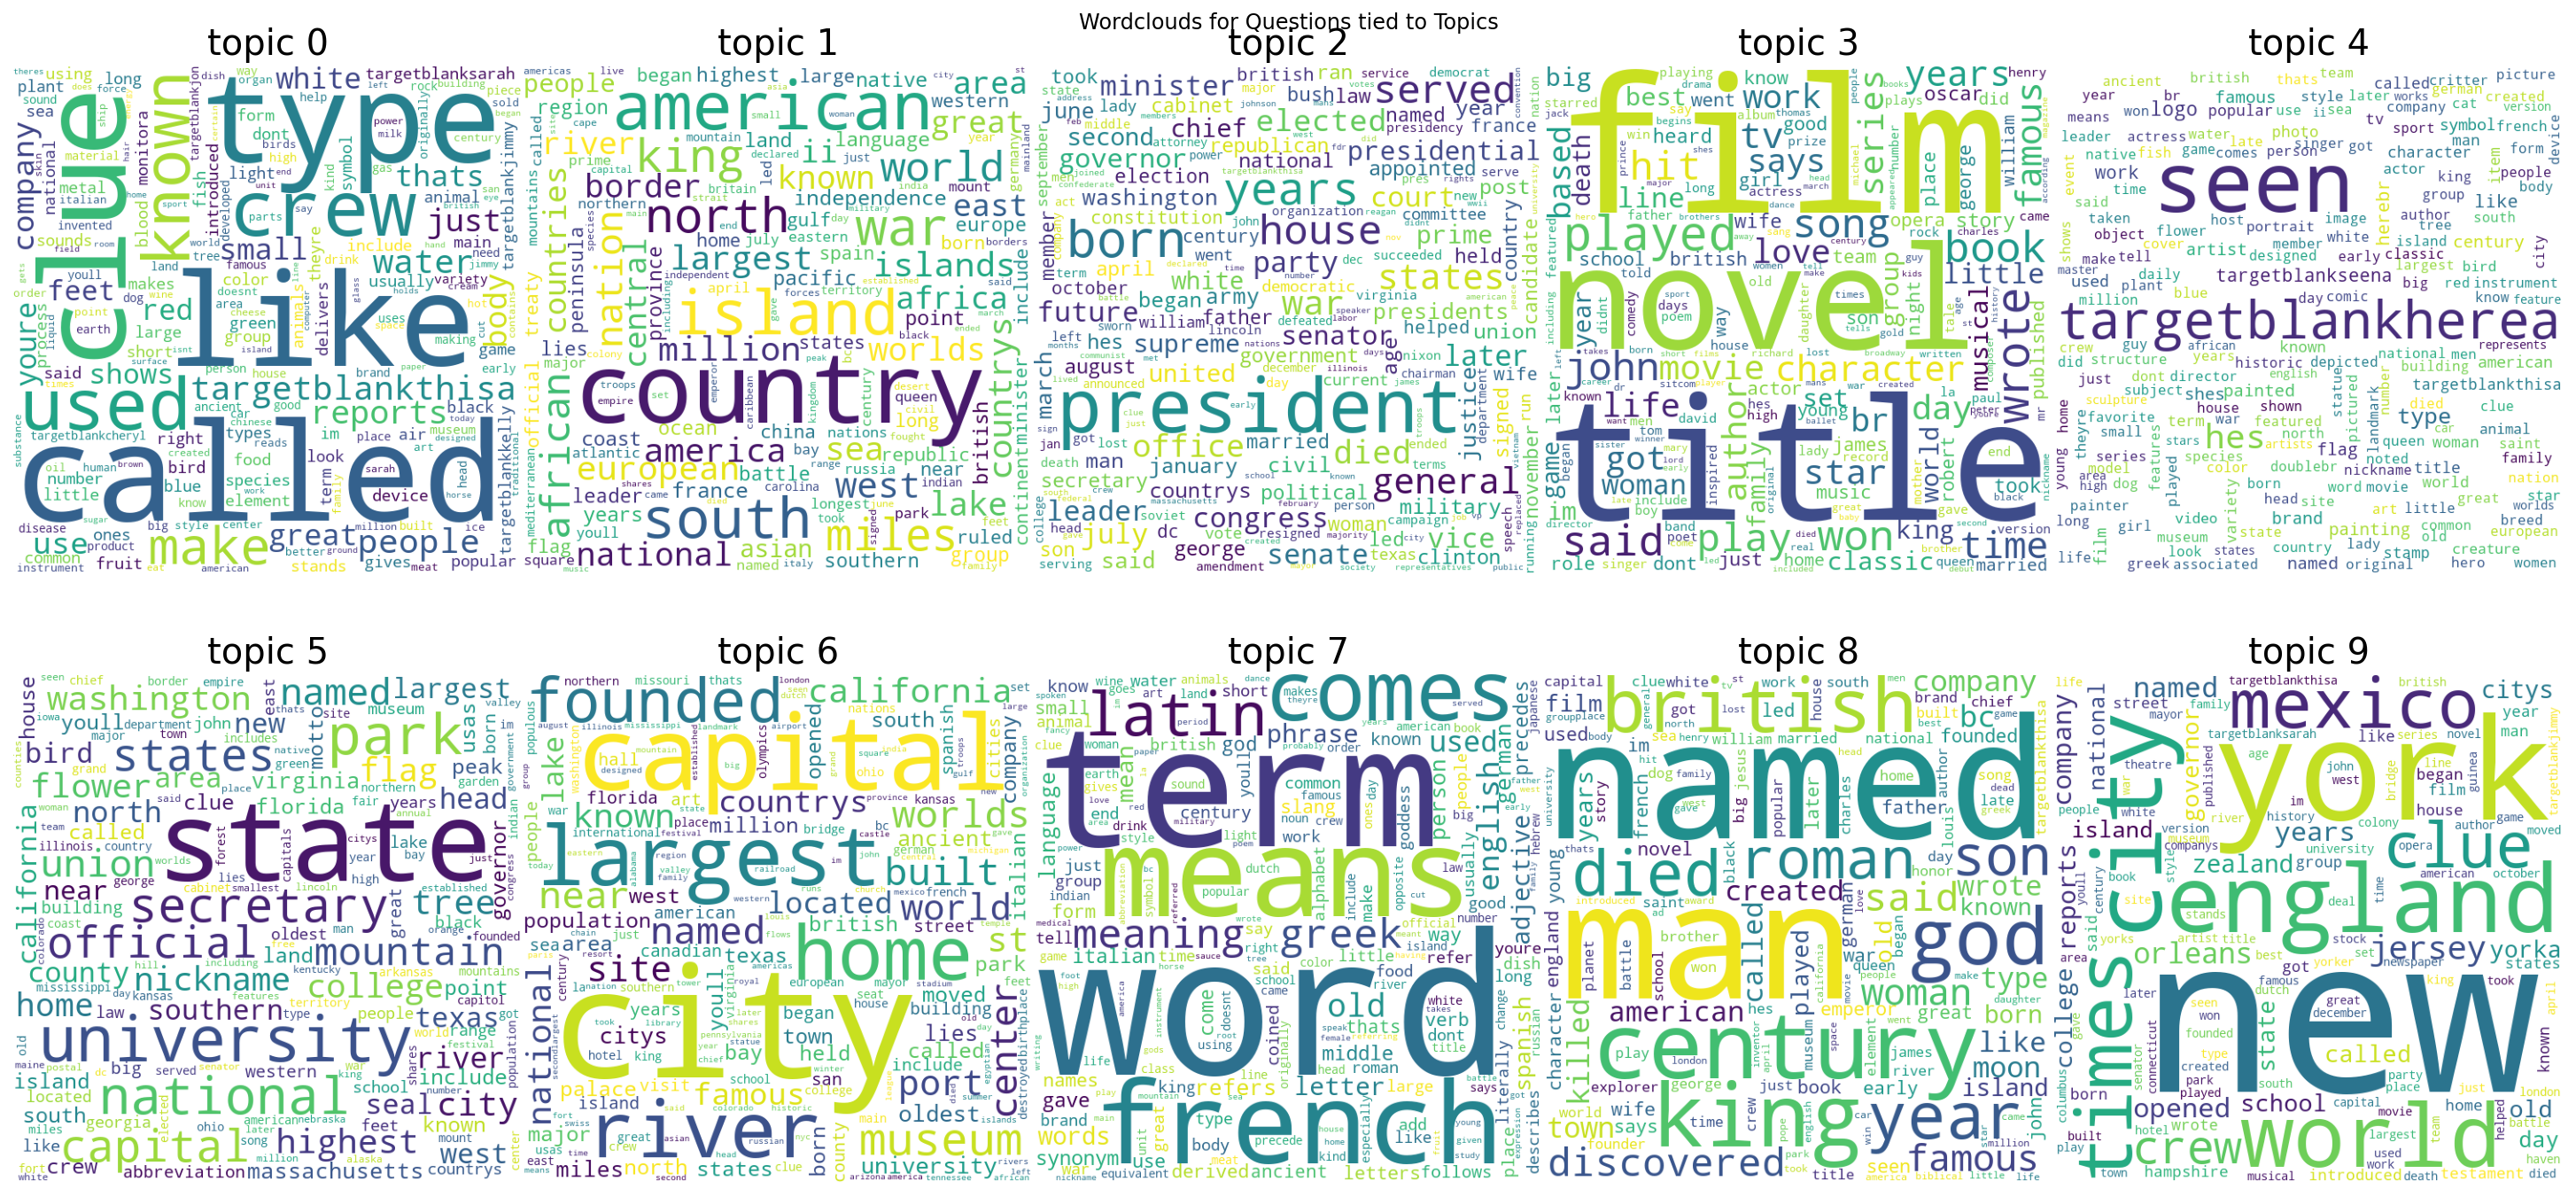

In [12]:
fig, axes = plt.subplots(2,5, figsize=(20,10), facecolor=None)

axes=axes.flatten()
for i, ax in enumerate(axes):
    wc = generate_wc(d[i])
    ax.imshow(wc)
    ax.set_title(f"topic {i}", fontsize=20)
    ax.axis("off")
    
plt.tight_layout(pad=0)
plt.suptitle("Wordclouds for Questions tied to Topics")
plt.show()

# 1: Most popular topics over time

Here we will examine how topics have changed over time (since 1984), mostly looking at the top 5 topics that appear in a given year.

First we need to tokenize and lemmatize all the questions.

In [13]:
lemma_questions = lemmatize(list(tokenize(list(df.question))), ['NOUN', 'VERB'])

In [38]:
id2word, corpus, lda = lda_topics(lemma_questions,20)

Here we'll show what each topic is

In [17]:
topic_df(lda,15)

Topic  1 Topic  2 Topic  3   Topic  4 Topic  5 Topic  6 Topic  7  Topic  8  \
0      city     name   people      title     give     clue     play       one   
1     woman      see     hold       love      end     crew     film      find   
2   company     word     turn       name     life     lead     star    create   
3      want     mean     land   nickname     john    leave     show    author   
4      team      use    point       bird   animal   report       tv    museum   
5     music     bear   battle  character     kill   school    movie       try   
6      york     term    sound       wife      put    build    title       art   
7     world     come     lose     nation    death   george  feature     think   
8      time     know    sport       keep      man     town     rock     event   
9    follow     type     sell       move     base   singer      son     marry   
10    start       br   france       tree    write     fall    actor  daughter   
11      see     wear      car        see     role   friend     hear    region   
12      win    greek    fight        eye     poet     sing    opera       fly   
13   street     girl     bill    version    color     hall    child    season   
14    cross     poem      use      henry  publish     band   appear    europe   

      Topic  9  Topic 10 Topic 11   Topic 12  Topic 13 Topic 14 Topic 15  
0        state      song      day       call      work   island      get  
1    president       hit      war      group      king     part       go  
2      capital     novel    write     number      come  country     type  
3       become     house    begin        god       man    river     make  
4         city    series     take        age     stand     name      say  
5         form      look    place        dog    leader     city   letter  
6      century   brother     line       food  language    water      die  
7        found     refer     year       need    family     mile      way  
8        serve      game     sign      power     night      sea   member  
9         head     title    thing  introduce     force      set   father  
10  university    record    month      march     speak     home      use  
11      person     cover    bring    produce    change  america      add  
12     college     write    april         mr      june     park      top  
13        fire      make     mark       rule  minister    state      eat  
14      center  describe     army       ride    become     lake      ask

In [41]:
ml = most_likely(corpus, lda)

In [77]:
df['topic'] = ml
df.head()

category   air_date  \
0                          HISTORY 2004-12-31   
1  ESPN's TOP 10 ALL-TIME ATHLETES 2004-12-31   
2      EVERYBODY TALKS ABOUT IT... 2004-12-31   
3                 THE COMPANY LINE 2004-12-31   
4              EPITAPHS & TRIBUTES 2004-12-31   

                                            question  value       answer  \
0  for the last  years of his life galileo was un...    200   Copernicus   
1  no   olympian football star at carlisle indian...    200   Jim Thorpe   
2  the city of yuma in this state has a record av...    200      Arizona   
3  in  live on the art linkletter show this compa...    200  McDonald\'s   
4  signer of the dec of indep framer of the const...    200   John Adams   

       round  show_number  year  topic  
0  Jeopardy!         4680  2004     13  
1  Jeopardy!         4680  2004      8  
2  Jeopardy!         4680  2004     18  
3  Jeopardy!         4680  2004      3  
4  Jeopardy!         4680  2004      8

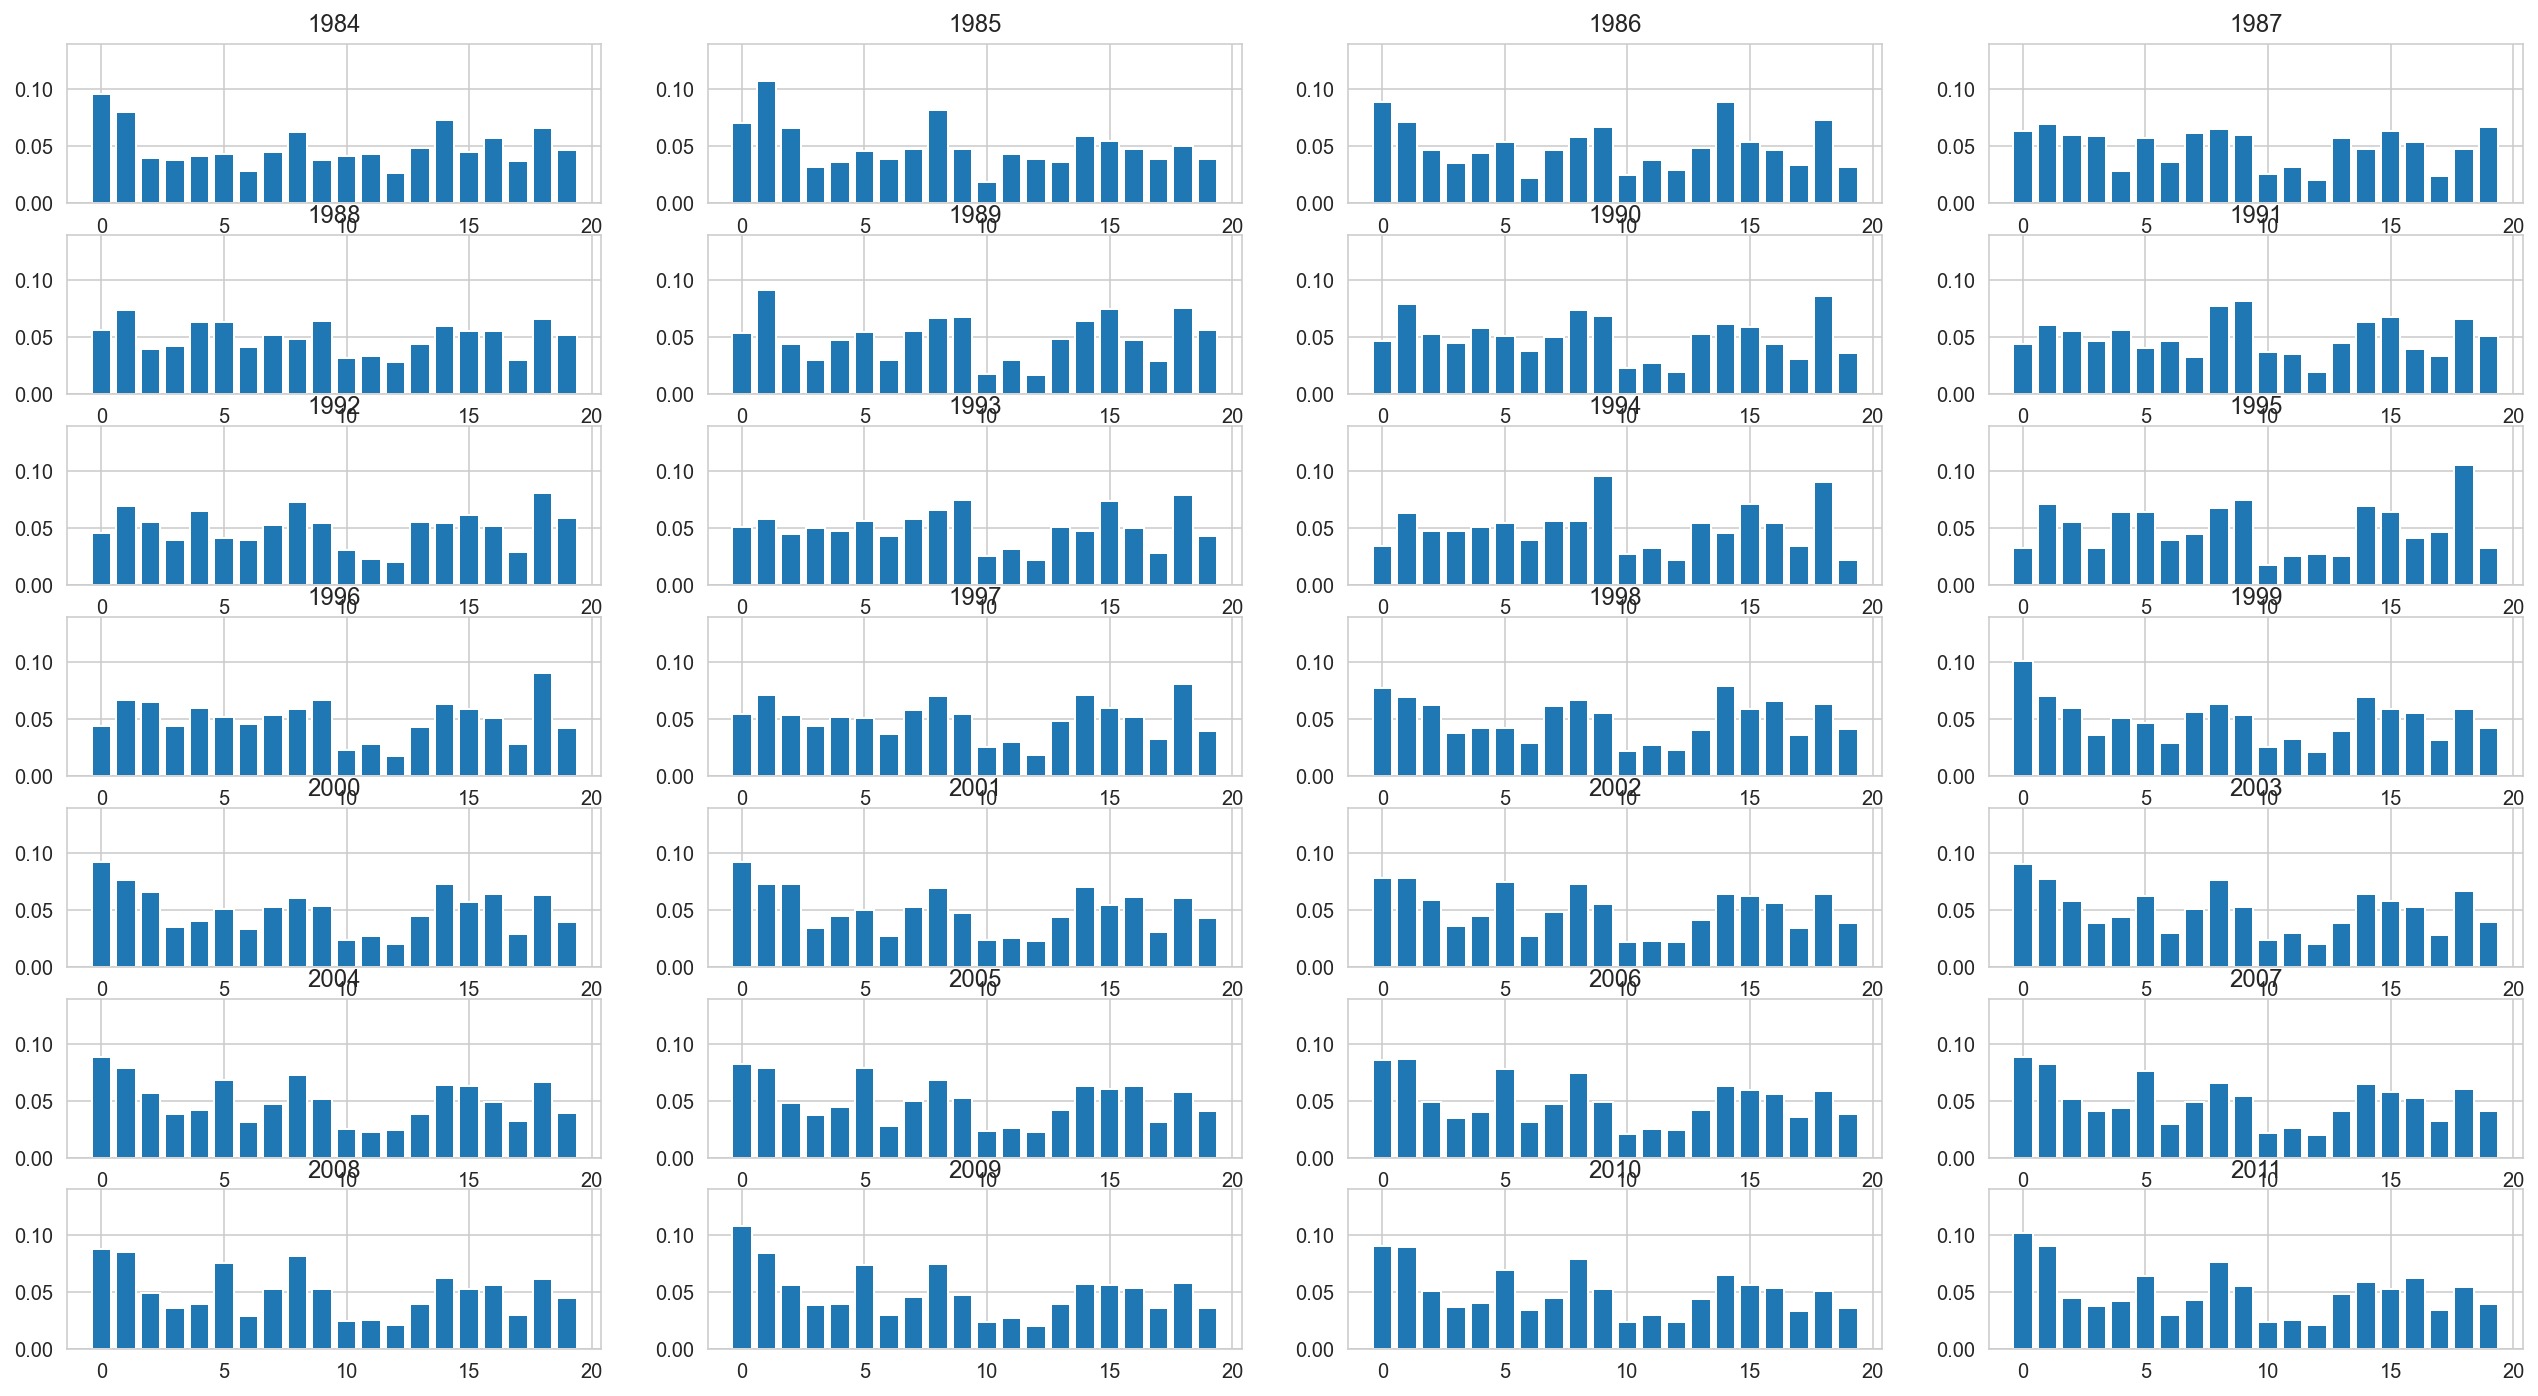

In [121]:
double_jeopardy = plot_distributions(dfs[0])

In [122]:
double_df = pd.DataFrame(double_jeopardy, index = range(1984, 2013), columns = [1,2,3,4,5])
double_df

1   2   3   4   5
1984   0   1  14  18   8
1985   1   8   0   2  14
1986   0  14  18   1   9
1987   1  19   8  15   0
1988   1  18   9   4   5
1989   1  18  15   9   8
1990  18   1   8   9  14
1991   9   8  15  18  14
1992  18   8   1   4  15
1993  18   9  15   8   1
1994   9  18  15   1   7
1995  18   9   1  14   8
1996  18   9   1   2  14
1997  18   1  14   8  15
1998  14   0   1   8  16
1999   0   1  14   8   2
2000   0   1  14   2  16
2001   0   1   2  14   8
2002   0   1   5   8  14
2003   0   1   8  18  14
2004   0   1   8   5  18
2005   0   1   5   8  14
2006   1   0   5   8  14
2007   0   1   5   8  14
2008   0   1   8   5  14
2009   0   1   8   5  18
2010   0   1   8   5  14
2011   0   1   8   5  16
2012   1   0  16   5   8

In [148]:
dbl = []
for col in double_df.columns:
    for val in double_df[col]:
        dbl.append(val)

In [150]:
Counter(dbl)

Counter({0: 19,
         1: 28,
         18: 15,
         9: 9,
         14: 19,
         8: 24,
         19: 1,
         15: 7,
         2: 5,
         5: 11,
         16: 4,
         4: 2,
         7: 1})

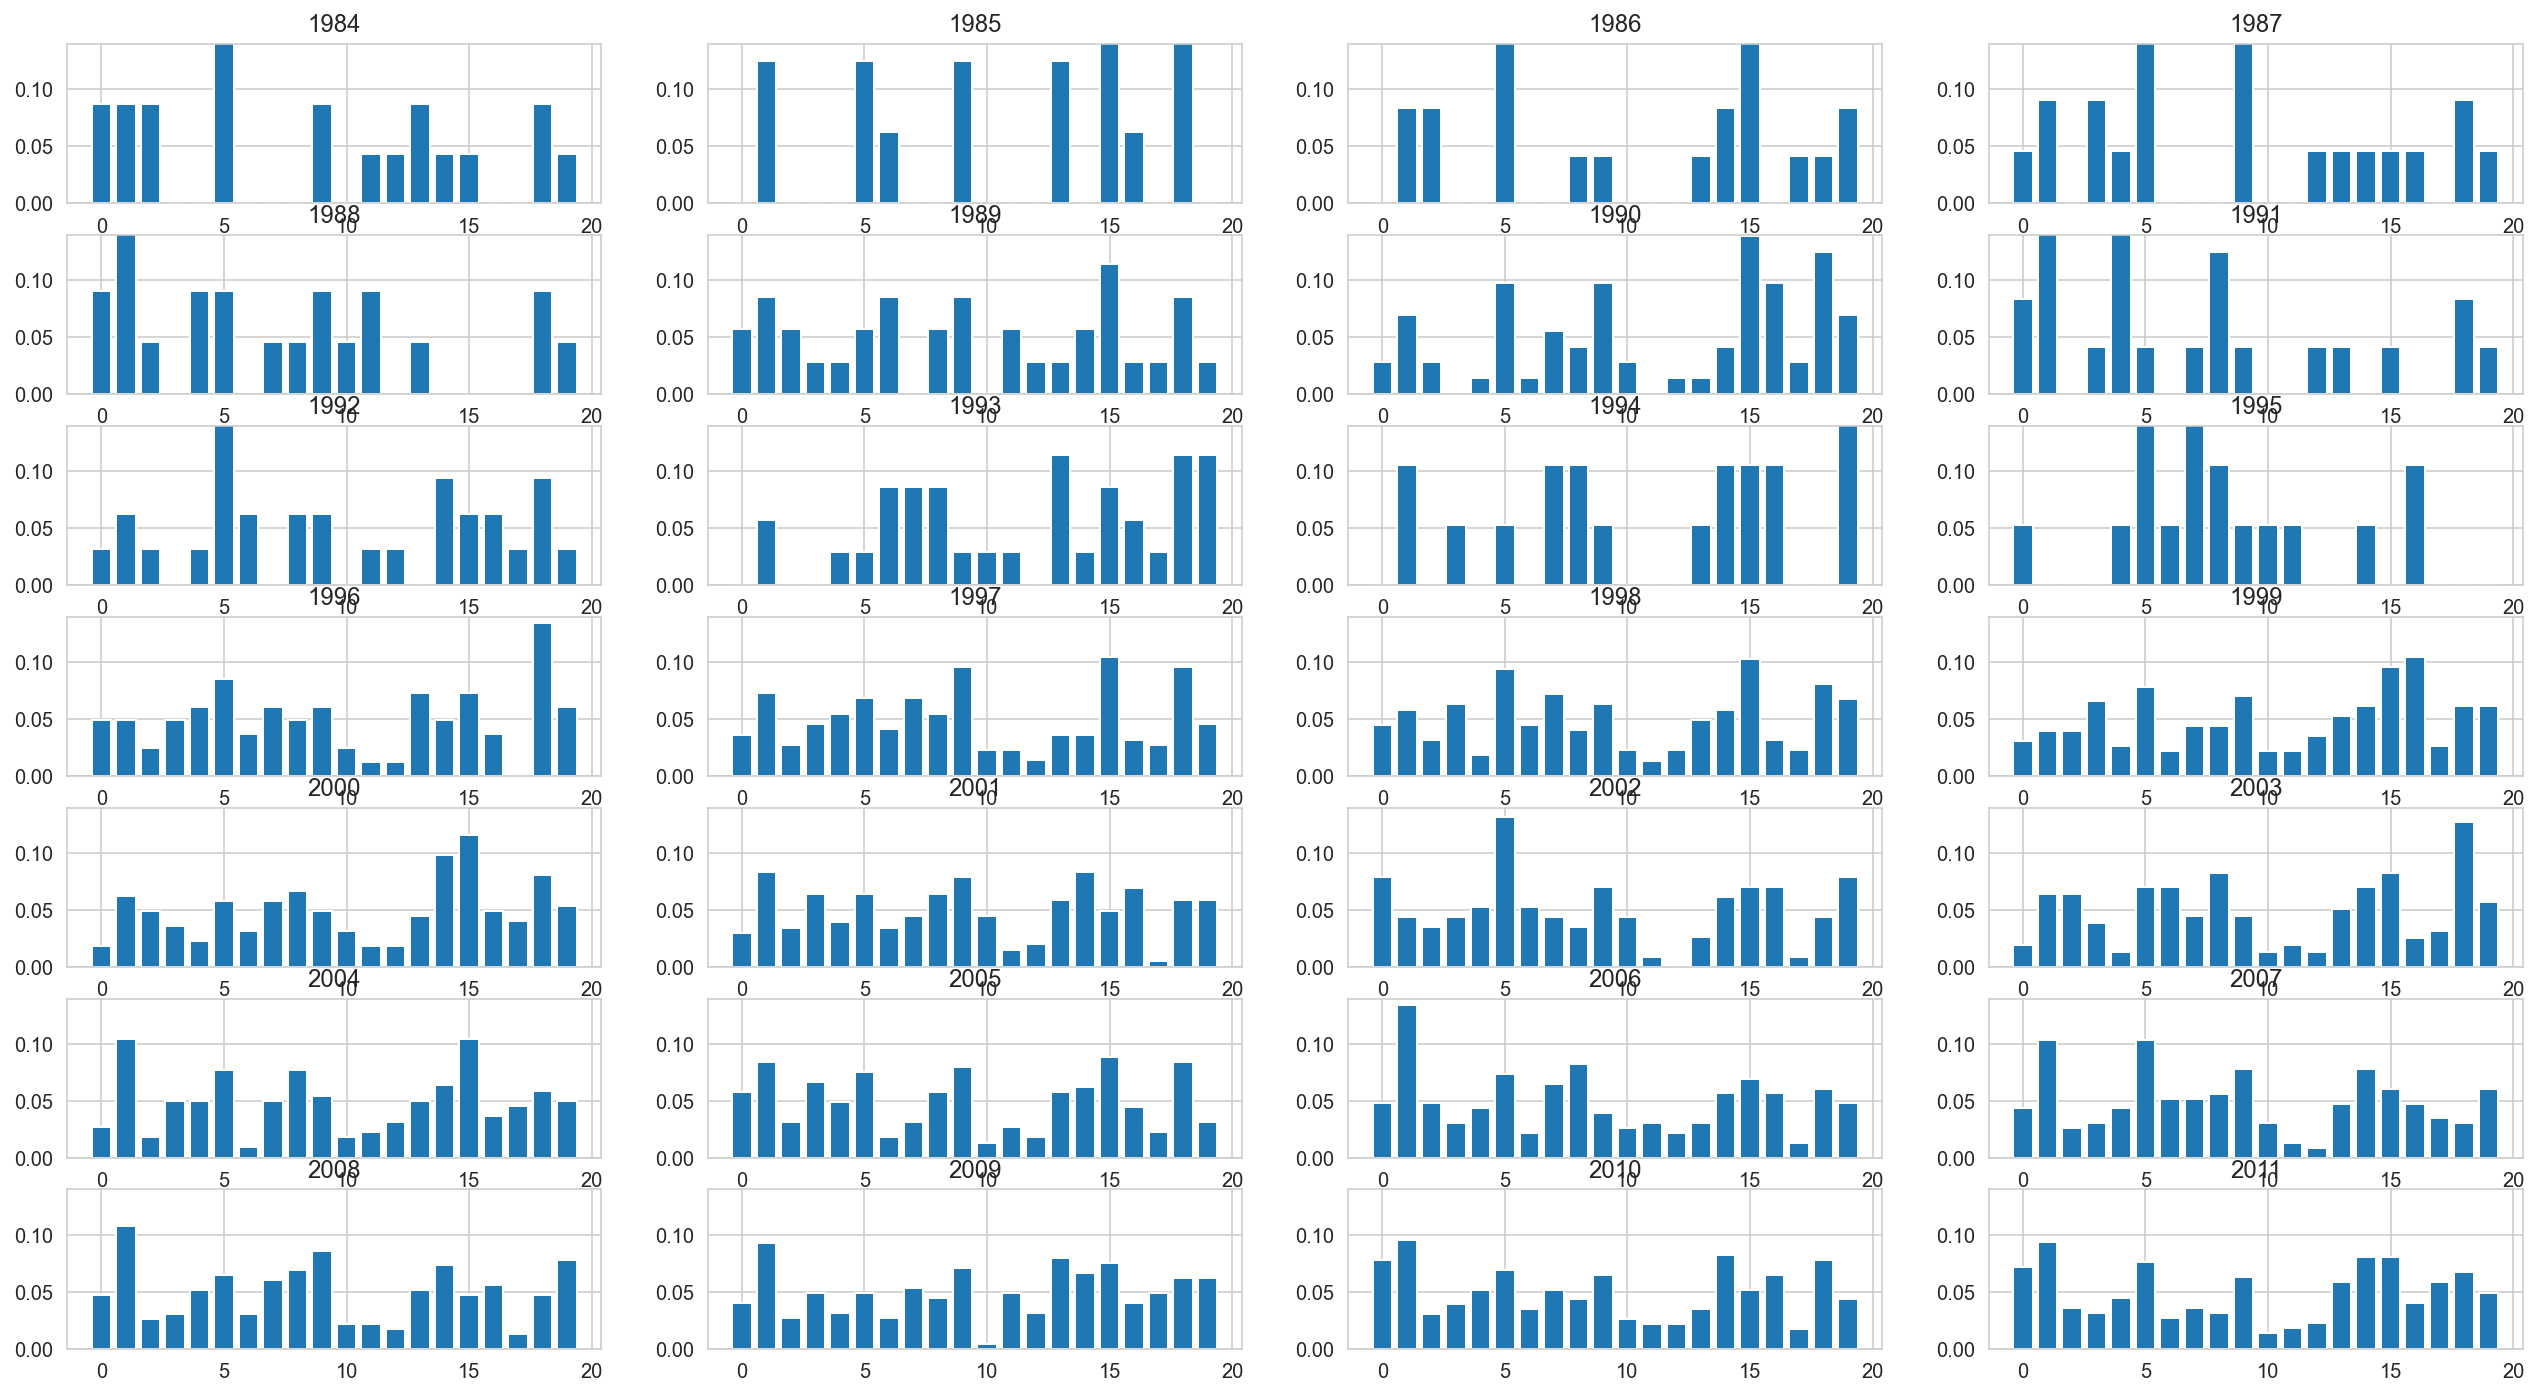

In [106]:
final_jeopardy = plot_distributions(dfs[1])

In [108]:
final_df = pd.DataFrame(final_idx, index = range(1984, 2013), columns = [1,2,3,4,5])
final_df

1   2   3   4   5
1984   5   0  13  18   9
1985  15  18   9   1   5
1986  15   5  19   1   2
1987   9   5   1   3  18
1988   1   0  11  18   5
1989  15   9   1  18   6
1990  15  18   9  16   5
1991   1   4   8   0  18
1992   5  14  18   9   1
1993  19  18  13  15   6
1994  19   1  16  15  14
1995   5   7  16   8   0
1996  18   5  15  13   9
1997  15   9  18   1   5
1998  15   5  18   7  19
1999  16  15   5   9   3
2000  15  14  18   8   1
2001   1  14   9  16   3
2002   5   0  19   9  16
2003  18  15   8  14   5
2004   1  15   5   8  14
2005  15   1  18   9   5
2006   1   8   5  15   7
2007   1   5   9  14  15
2008   1   9  19  14   8
2009   1  13  15   9  14
2010   1  14   0  18   5
2011   1  15  14   5   0
2012  15   4   9   1  18

In [151]:
final = []
for col in final_df.columns:
    for val in final_df[col]:
        final.append(val)
Counter(final)

Counter({5: 20,
         15: 19,
         9: 16,
         1: 20,
         19: 6,
         18: 17,
         16: 6,
         0: 7,
         4: 2,
         14: 11,
         7: 3,
         8: 7,
         13: 4,
         11: 1,
         3: 3,
         2: 1,
         6: 2})

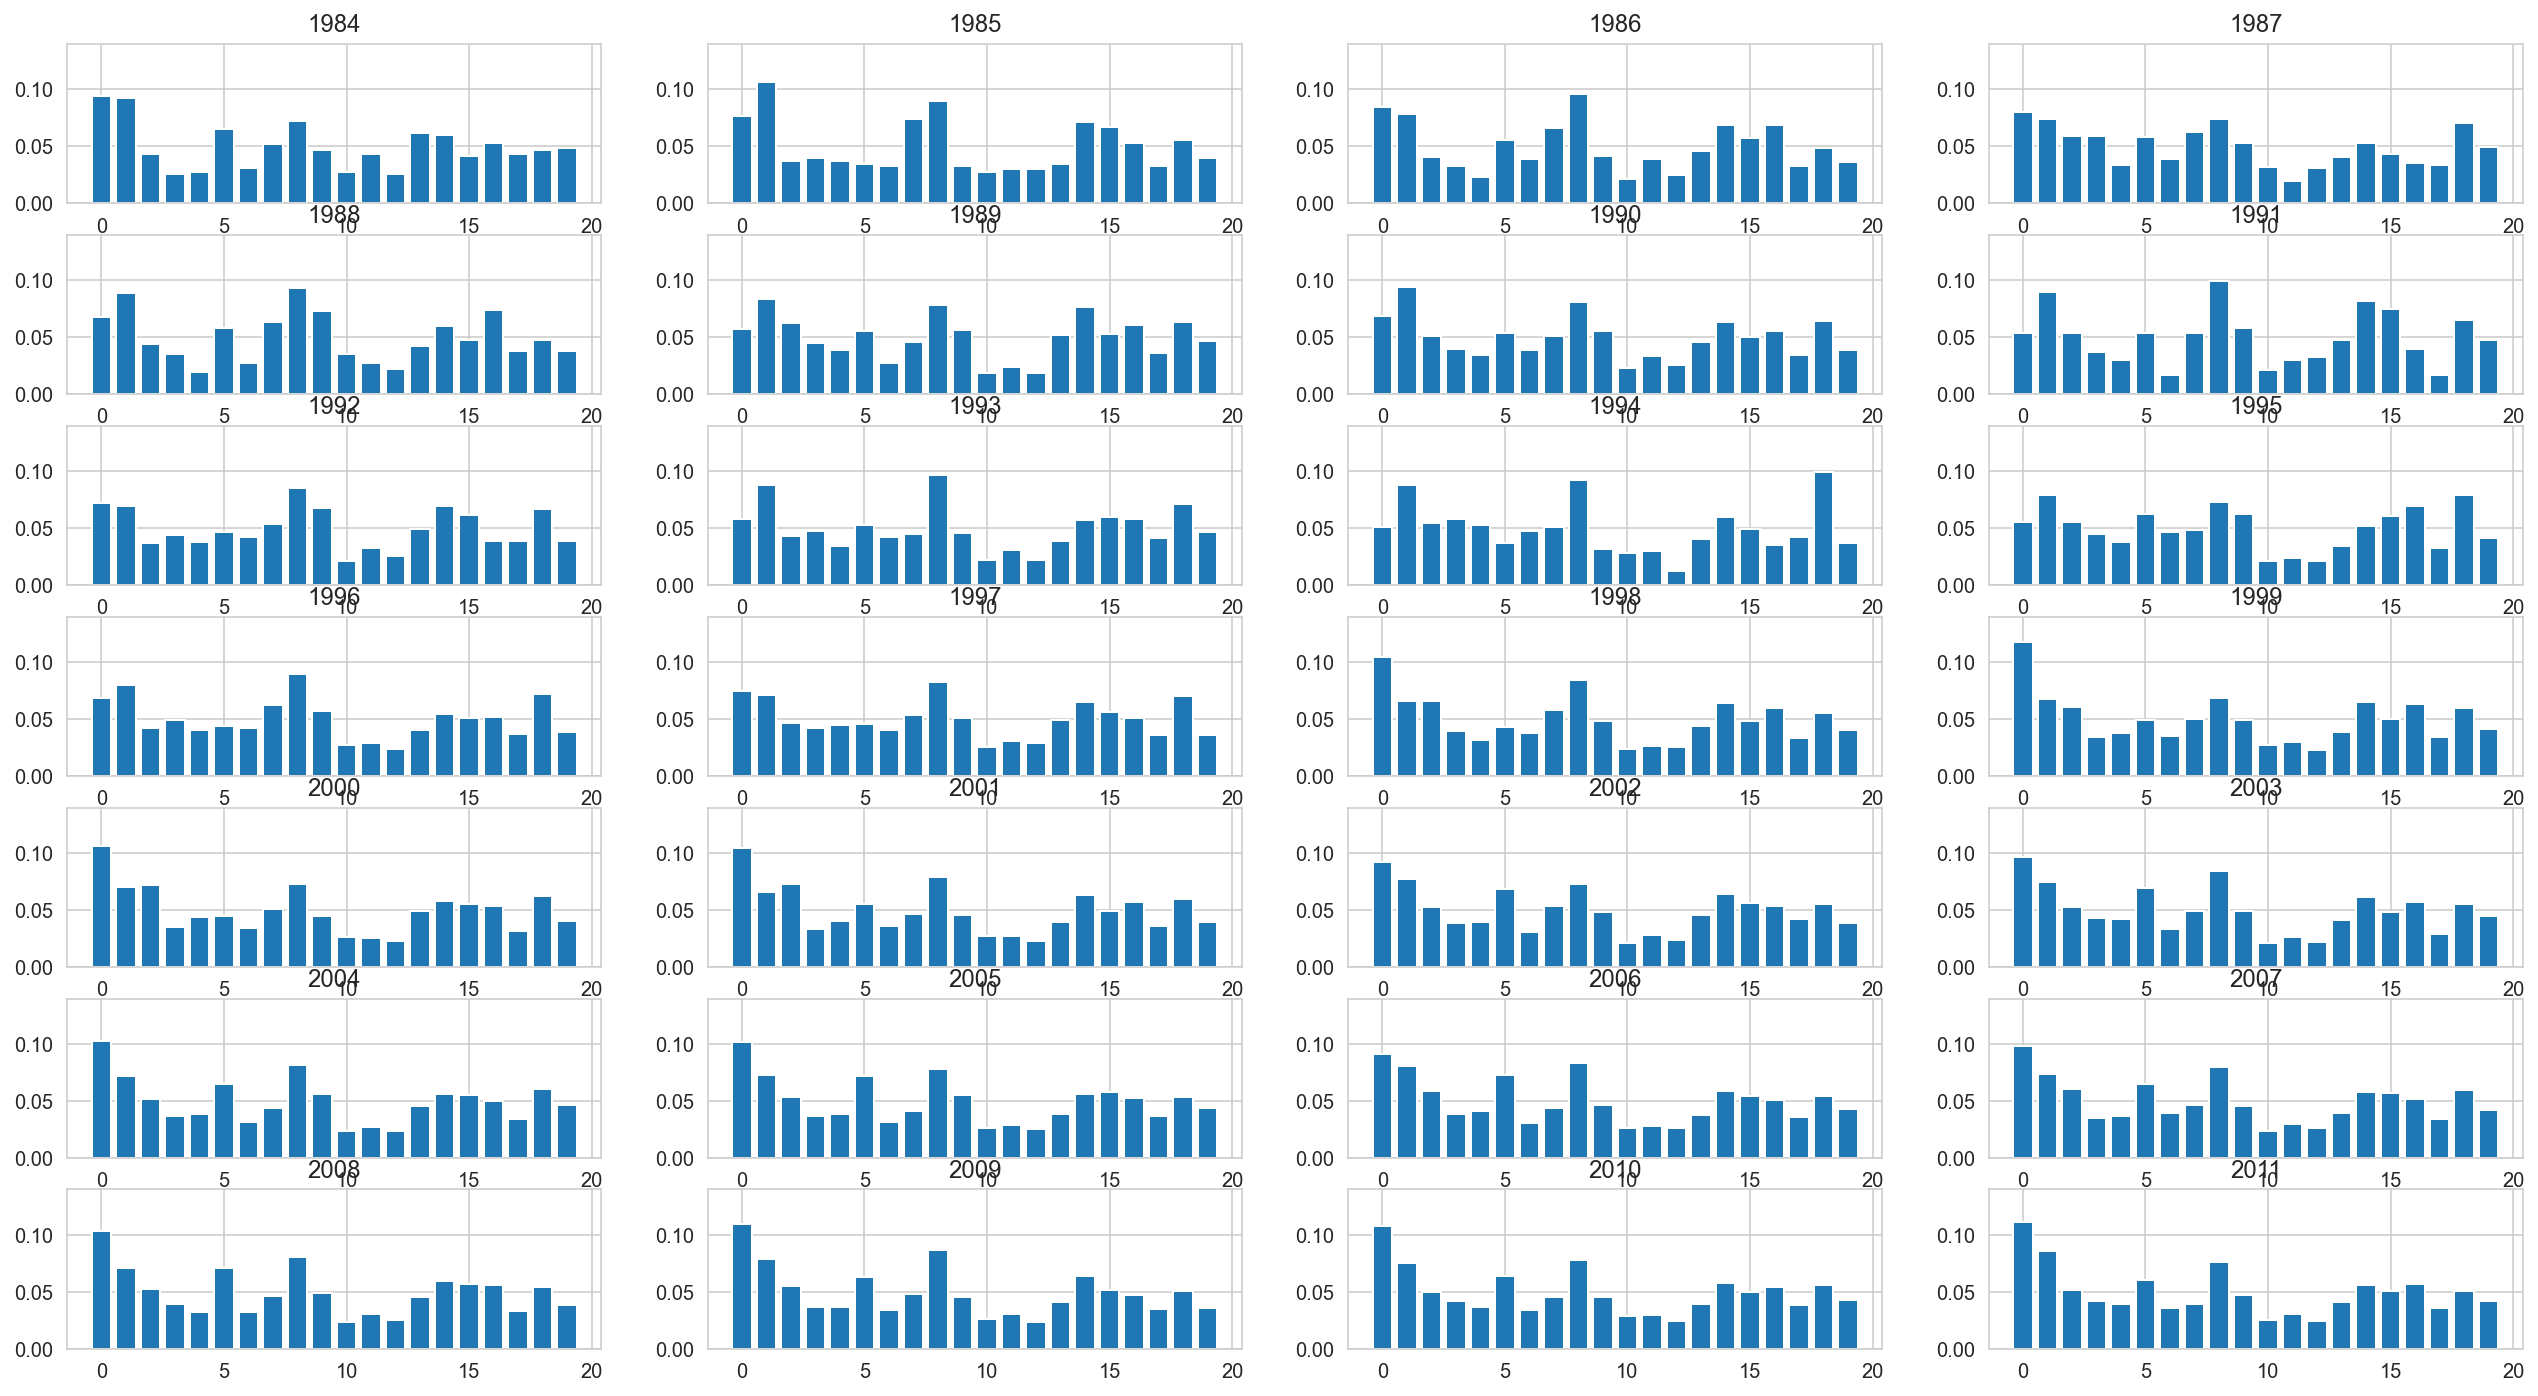

In [153]:
jeopardy = plot_distributions(dfs[2])

In [154]:
jeopardy_df = pd.DataFrame(jeopardy, index = range(1984, 2013), columns = [1,2,3,4,5])
jeopardy_df

1   2   3   4   5
1984   0   1   8   5  13
1985   1   8   0   7  14
1986   8   0   1  16  14
1987   0   1   8  18   7
1988   8   1  16   9   0
1989   1   8  14  18   2
1990   1   8   0  18  14
1991   8   1  14  15  18
1992   8   0   1  14   9
1993   8   1  18  15   0
1994  18   8   1  14   3
1995   1  18   8  16   9
1996   8   1  18   0   7
1997   8   0   1  18  14
1998   0   8   1   2  14
1999   0   8   1  14  16
2000   0   8   2   1  18
2001   0   8   2   1  14
2002   0   1   8   5  14
2003   0   8   1   5  14
2004   0   8   1   5  18
2005   0   8   1   5  15
2006   0   8   1   5  14
2007   0   8   1   5   2
2008   0   8   5   1  14
2009   0   8   1  14   5
2010   0   8   1   5  14
2011   0   1   8   5  16
2012   0   1   8   2  15

In [155]:
single = []
for col in jeopardy_df.columns:
    for val in jeopardy_df[col]:
        single.append(val)
Counter(single)

Counter({0: 25,
         1: 29,
         8: 29,
         18: 11,
         16: 5,
         14: 17,
         2: 6,
         5: 11,
         7: 3,
         9: 3,
         15: 4,
         13: 1,
         3: 1})

#### Q1 - Summary

When comparing the topics between each of the three rounds of `Jeopardy!` we found that the most common topics used in the `Jeopardy!` and `Double Jeopardy!` rounds are very similar. Their top 5 topics share 0, 8, 10, 11. This tells us that contestants can safely assume that these topics are worth reviewing, as they have a higher probability of appearing during the game. `Final Jeopardy!` also included topics 8 & 11, but were mostly different, as compared to the other two rounds.

While looking at the last 15 years for the `Jeopardy!` round, we noticed that topics 0 and 10 occurred very frequently, whereas topics 16 & 18 have not yet made it to the top 5.

The diversity of questions over time for the `Final Jeopardy!` round appear to have increased in recent years, as the top 5 topics have rarely repeated.

Given the preponderance of data here, it's safe to say that the themes for the first two rounds have some familiar topics, while `Final Jeopardy!` topics are more spread out and inconsistent over time (maybe to due with the fact that it's 1 topic vs 6 topics for the other two rounds, less chance to repeat)

# 2: Difficulty of Questions Over Time
## a) Comparing topics between difficulty levels in Jeopardy! and Double Jeopardy! rounds
Now we are going to look at how topics in different difficulty levels compare between the Jeopardy! and Double Jeopardy! rounds. An issue we encountered early on is that as the number of topics increase, it becomes increasingly difficult, complex, and expensive to compare and analyze each topic carefully. For the purposes of the following experiments, we decided to perform NMF for 25 topics per round-difficulty combination. Then when comparing across groups, we will use only the top 5 most common topics per question. If we had instead used only 5 topics initially, we most likely would not have captured enough variety in topic groups, leading to leakage between groups. So taking the top 5 most common topics from a group of 25 allows us to choose from the variety of topics those most relevant to the round-difficulty combination. In order to obtain these topics, we compute the term-topic matrix from NMF. Then, we look at the sorted rows of the matrix as a topic group. These sorted values represent the most relevant terms, in descending order, to the topic corresponding to that row.
### `Jeopardy!` Round

In [3]:
jeopardy_df = get_difficulty(df.loc[df['round'] == 'Jeopardy!', :])

In [12]:
j_results = get_relevancies(jeopardy_df, 25, 5)

col: difficulty, val: 1: Computing topics...
	1: Finding word relevancies...
	1: Finding top 25 most common topics...
col: difficulty, val: 2: Computing topics...
	2: Finding word relevancies...
	2: Finding top 25 most common topics...
col: difficulty, val: 3: Computing topics...
	3: Finding word relevancies...
	3: Finding top 25 most common topics...
col: difficulty, val: 4: Computing topics...
	4: Finding word relevancies...
	4: Finding top 25 most common topics...
col: difficulty, val: 5: Computing topics...
	5: Finding word relevancies...
	5: Finding top 25 most common topics...
col: difficulty, val: 6: Computing topics...
	6: Finding word relevancies...
	6: Finding top 25 most common topics...


### `Double Jeopardy!` Round

In [6]:
dbl_df = get_difficulty(df.loc[df['round'] == 'Double Jeopardy!'])

In [13]:
dbl_results = get_relevancies(dbl_df, 25, 5)

col: difficulty, val: 1: Computing topics...
	1: Finding word relevancies...
	1: Finding top 25 most common topics...
col: difficulty, val: 2: Computing topics...
	2: Finding word relevancies...
	2: Finding top 25 most common topics...
col: difficulty, val: 3: Computing topics...
	3: Finding word relevancies...
	3: Finding top 25 most common topics...
col: difficulty, val: 4: Computing topics...
	4: Finding word relevancies...
	4: Finding top 25 most common topics...
col: difficulty, val: 5: Computing topics...
	5: Finding word relevancies...
	5: Finding top 25 most common topics...
col: difficulty, val: 6: Computing topics...
	6: Finding word relevancies...
	6: Finding top 25 most common topics...


## Comparison
We now want to find any similarities between the topics at different difficulty levels. At first, I thought we would only need to compare questions at the same difficulty level, but from some testing I found there were similarities between topics in different difficulty levels. In order to understand the total relatedness of the difficulty-topic groups between rounds, we will construct a similarity matrix, where cell $i, j$ represents the 'mean-max' Jaccard similarity index between Jeopardy! difficulty $i$ and Double Jeopardy! difficulty $j$. 'Mean-max' Jaccard score is an idea we created to compare all the sub groups in two sets. The idea is to find the maximum Jaccard similarity between each subset in set A and every other subset in set B. Then we take the average of all those scores to determine the average of the strongest relationships between groups.

When computing the Jaccard similarity matrix, we realized that if we compared the full list of terms between topics, the Jaccard scores would all increase, because with more terms, there is a higher chance that more terms will be shared between topics. So, we set a parameter for the max number of terms to compare between topics to prevent false positive relationships. This gives us flexibility to see how the relationships change when increasing the maximum number of terms to compare. As a note, since we take these terms in order of their relevancy to a topic, we are essentially comparing the 'top' terms between topics. After some testing, since there are about 9,000 terms in each topic list, we chose 500 for our maximum number of terms to compare.

In [17]:
J = []
for difficulty in j_results.values():
    J.append(difficulty['top'])
    
D = []
for difficulty in dbl_results.values():
    D.append(difficulty['top'])

This Jaccard matrix gives us the min-max normalized mean-max Jaccard similarities between different difficulty levels in 'Jeopardy!' and 'Double Jeopardy!' rounds. This gives us a sense of how similar topic groups are relative to each other. Even for fairly similar topics, the Jaccard score isn't very high and when topics are very dissimilar, the Jaccard score is extremely small. So, we first take the $ln$ of the Jaccard scores, then min-max normalize the values. This gives us relative values, where a 1 corresponds to the 2 most similar difficulty levels. The nodes in the plot represent difficulty levels in different rounds of Jeopardy, and two nodes are connected if their normalized Jaccard similarity score is above a certain threshold. By default, we are using 0.8. The plot can be modified to plot _all_ connections and use the Jaccard score as an alpha value of the edges, but this results in a very cluttered picture, so we went the threshold route.

In [18]:
Jaccard_matrix = compute_similarities(J, D, max_elements=500)
Jaccard_matrix

1       2       3       4       5       6
1  0.6226  0.6569  0.6629  0.6425  0.3211  0.3201
2  0.6497  0.6323  0.6497  0.6970  1.0000  0.6419
3  0.6128  0.8790  0.0553  0.6206  0.0464  0.5853
4  0.5844  0.2926  0.0281  0.3201  0.3101  0.9688
5  0.6126  0.9692  0.9734  0.6536  0.6385  0.3222
6  0.3112  0.5866  0.5861  0.8970  0.0000  0.6060

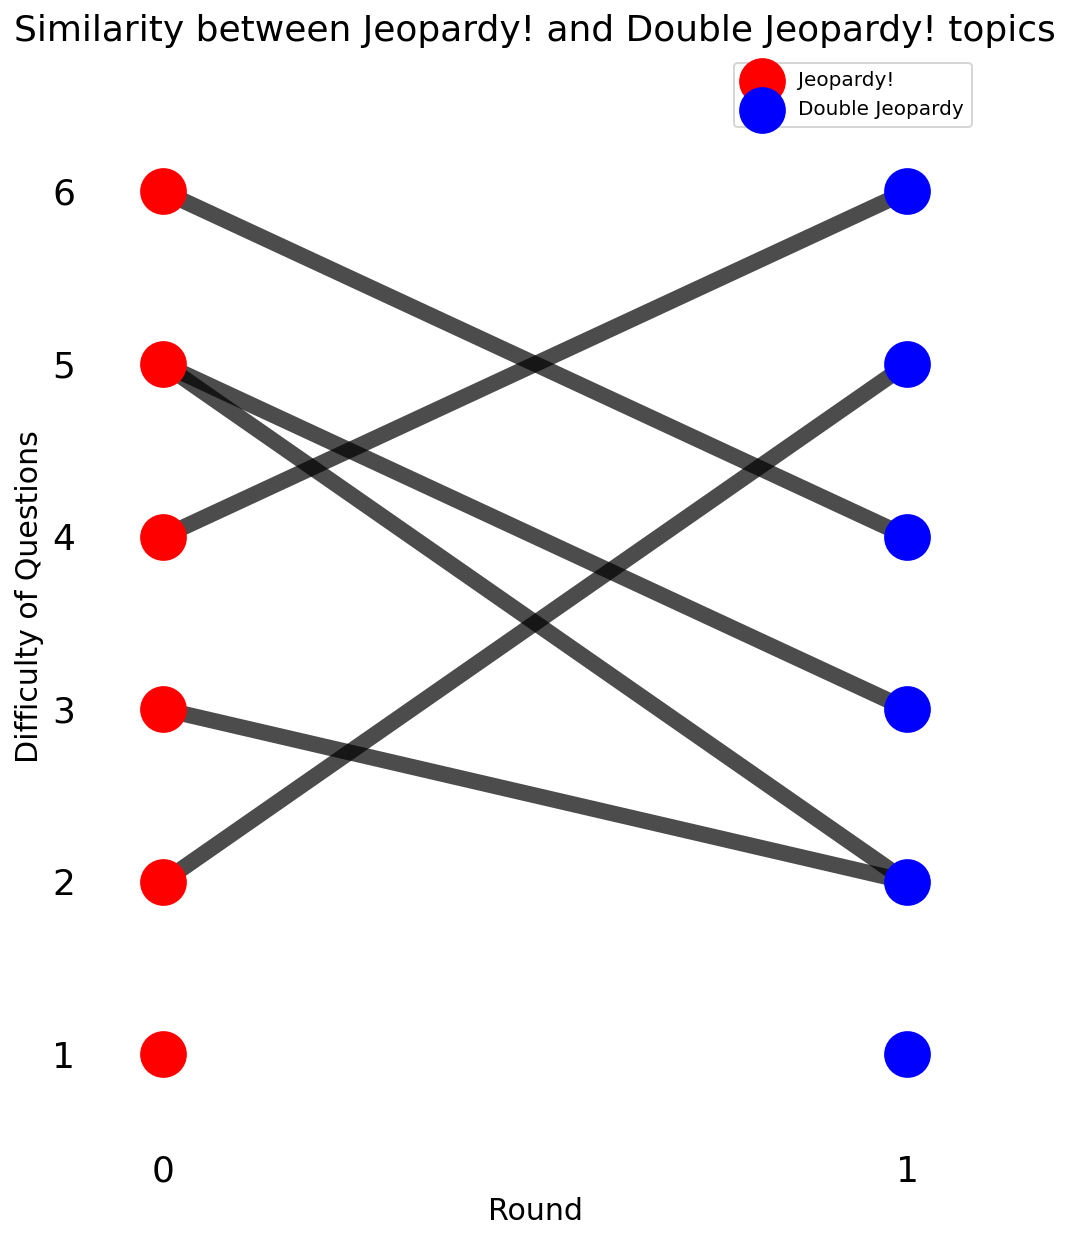

In [20]:
plot_Jaccard_matrix(Jaccard_matrix, threshold=0.8)

Based on various NMF runs and Jaccard matrix plots, we can make a few observations.
1) There isn't a clear link between topics at the difficulty level. In all of the NMF runs, there weren't consistently strong links between the same difficulty levels in 'Jeopardy!' and 'Double Jeopardy!'. A few times, we found strong links between the difficulty 1 and 6 questions in both rounds, but again, it wasn't consistent. If there was a strong relationship between topics and difficulty, we would expect to see straight bars connecting nodes in the same difficulty level in our plot.
2) The Jaccard similarity matrices vary a lot from run to run. Due to the high level of aggregation involved, this variance makes some sense, but it's hard to say exactly why the topics vary so much. One reason could be that we aren't handling 'Daily Double' questions specifically, so their non-static monetary values could be affecting performance of the models.
3) The strongest links appear to be between different difficulty groups. One consistent pattern we found was that difficult questions (4, 5, 6) in the 'Jeopardy!' round often had strong links to easy questions (1, 2, 3) in the 'Double Jeopardy!' round. This may be because the 'Double Jeopardy!' questions are harder, so it would make sense that the 'easy' questions in this round have similar topics to difficult questions in the 'Jeopardy!' round.

Though the results vary widely, I think the biggest takeaway from this part of our analysis is that topics are probably not tied to difficulty. I think that the high variability in connections means that any given topic can have both easy and difficult questions. As an extension, it would be interesting to compare different similarity metrics to Jaccard. 

## b) Comparing topics per difficulty over time
Now, we are going to take a look at Jaccard similarities between difficulty groups over time. For this analysis, we are going to look just at similarities between the same difficulty levels over time. For instance, we will look at the mean-max Jaccard similarity between the topics of difficulty level 1 for 'Jeopardy!' and 'Double Jeopardy!' over time, then look at the same for difficulty level 2 and so on. In order to achieve this, we are going to plot the mean-max the Jaccard similarities over time. Since each year contains a varying level of data, the size of term lists per topic can vary a lot as well. Due to this, we need to change 'max_elements' over time. The easiest way to do this is find the smallest term list between two topic groups and then use a percentage of that number. For example, if we have two topic groups, each with 5 topics each, we have to look at 10 term lists. We find the smallest one, and then use a fraction of that size for our comparison. We chose to use 30% for our fraction of terms.

In [56]:
years = sorted(df.year.unique())

difficulty_similarities = defaultdict(list)

for year in years:
    year_df = df.loc[df.year == year, :]
    
    jeopardy_df = get_difficulty(year_df.loc[year_df['round'] == 'Jeopardy!', :])
    j_results = get_relevancies(jeopardy_df, 25, 5, verbose=False, min_df=0, max_df=1)
    
    dbl_df = get_difficulty(year_df.loc[year_df['round'] == 'Double Jeopardy!', :])
    dbl_results = get_relevancies(dbl_df, 25, 5, verbose=False, min_df=0, max_df=1)
    
    for difficulty in range(1,7):
        J_topics = j_results[difficulty]['top']
        D_topics = dbl_results[difficulty]['top']
        
        smallest_J = min(map(len, J_topics))
        smallest_D = min(map(len, D_topics))
        max_terms = int(min(smallest_J, smallest_D)*.3)  # get max terms
        
        similarity = mean_max_Jaccard(J_topics, D_topics, max_elements=max_terms)
        difficulty_similarities[difficulty].append(similarity)

/Users/zach.dougherty/anaconda3/envs/torch_env/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:111: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(res * 2)


Now, we are going to plot the similarities of difficulty levels over time and see if we can find some relationship. Using the raw mean-max Jaccard scores gives natural boundaries of 0 and 1 for nice comparisons.

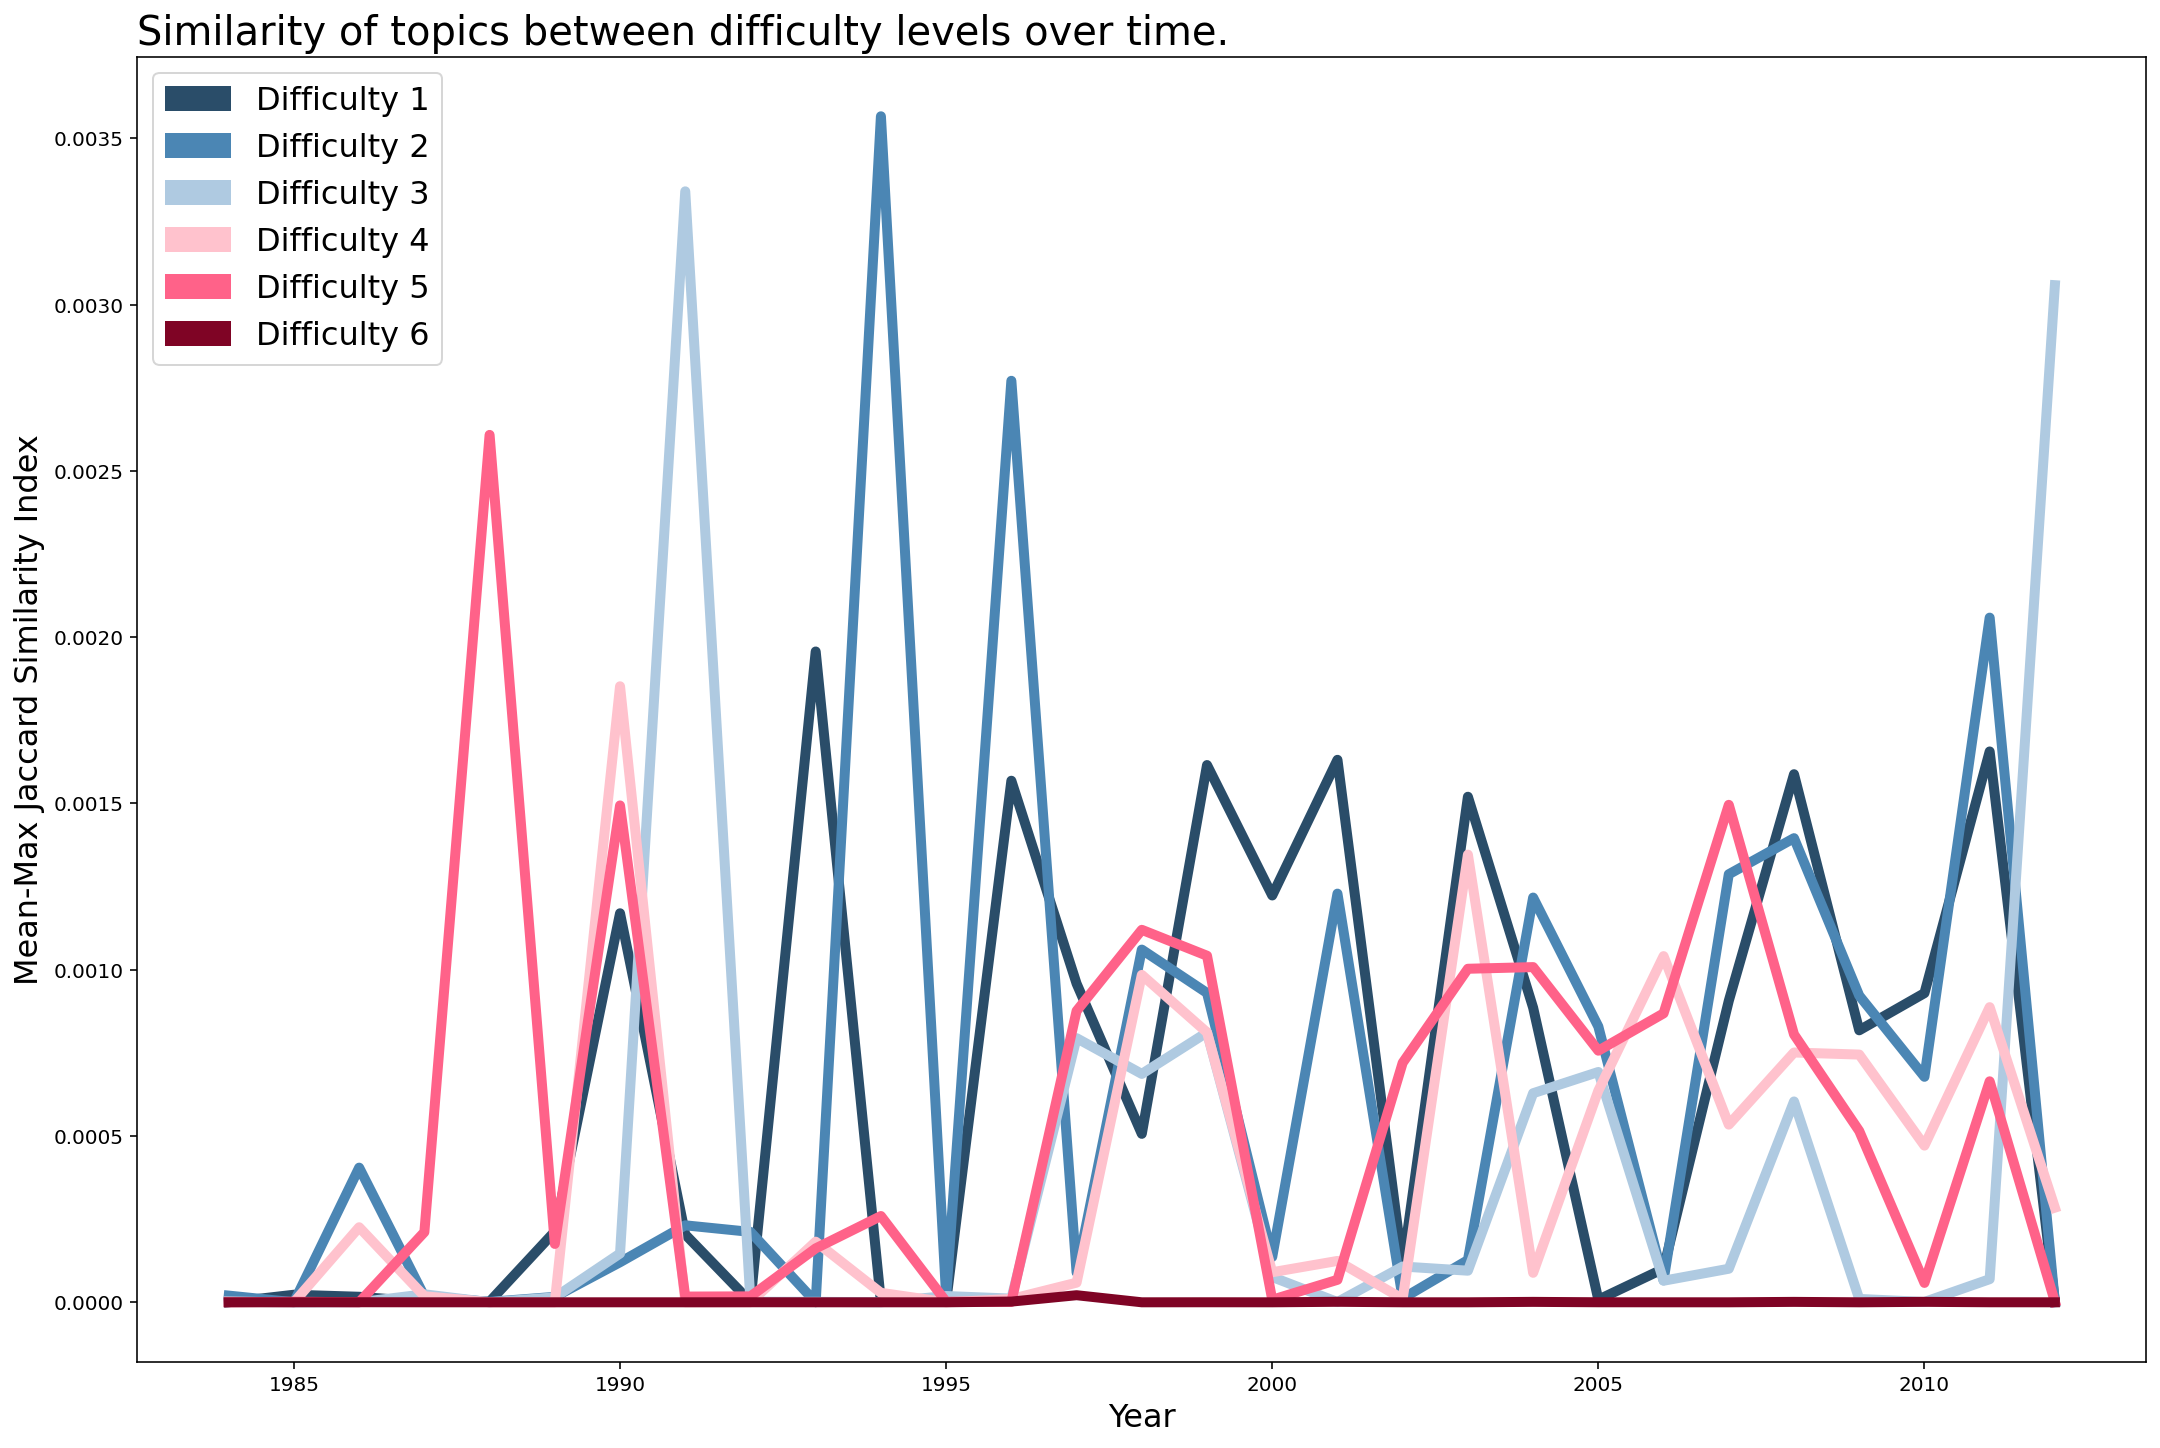

In [57]:
fig, ax = plt.subplots(figsize=(18,12))

colors = {
    1: '#2a4d69',
    2: '#4b86b4',
    3: '#AFCAE1',
    4: '#ffc2cd',
    5: '#ff6289',
    6: '#7f0425'
}

handles = []
for difficulty in range(1,7):
    ax.plot(years, np.exp(np.array(difficulty_similarities[difficulty])), '-', c=colors[difficulty], lw=5)
    handles.append(mpatches.Patch(color=colors[difficulty], label=f'Difficulty {difficulty}'))
    
ax.legend(handles=handles, fontsize=16)
ax.set_title("Similarity of topics between difficulty levels over time.", fontsize=20, loc='left')
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Mean-Max Jaccard Similarity Index', fontsize=16)
plt.show()

The first major observation is that the Difficulty 6 questions have almost no similarity across the lifespan of the entire show, as signified by the dark red line at the bottom. We can also see that Difficulty 3 also has a low level of similarity except for a brief spike in 1991. The rest of the levels seem fairly sporadic. 

Looking at the limits of the y-axis, this plot is actually quite misleading. Jaccard similarity scores are on a range of [0,1], with 1 representing two identical sets. The maximum Jaccard similarity over the entire span is only about 0.0035. I think that this simple fact tells us the most information about the sequences we see, as it tells us that none of the difficulty levels really show a significant similarity across Jeopardy rounds. One conclusion is that, like previously discussed, topics are not linked to difficulty and topics can contain a wide range of difficulty level questions. One other reason we don't have interesting results is that there isnt a lot of data for some years. For instance, there are only 872 questions from the 1985 while there are almost 14,000 questions for 2008. If we had more questions for each year, we may be able to get better results.